In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, confusion_matrix, classification_report
import xgboost as xgb

import pandas as pd

In [4]:
shots_df = pd.read_csv("C:/Users/student/Downloads/shots_2015-2023.zip")

In [5]:
print(shots_df.head())
print(shots_df.info())
print(shots_df.isnull().sum())

   shotID homeTeamCode awayTeamCode  season  isPlayoffGame  game_id  \
0       0          TBL          NSH    2023              0    20001   
1       1          TBL          NSH    2023              0    20001   
2       2          TBL          NSH    2023              0    20001   
3       3          TBL          NSH    2023              0    20001   
4       4          TBL          NSH    2023              0    20001   

   homeTeamWon  id  time  timeUntilNextEvent  ...    xFroze  xRebound  \
0            1  10    61                 9.0  ...  0.249174  0.035816   
1            1  11    70                26.0  ...  0.107945  0.051284   
2            1  13   107                 2.0  ...  0.236193  0.030269   
3            1  19   177                35.0  ...  0.198635  0.033686   
4            1  21   231                29.0  ...  0.188582  0.027146   

  xPlayContinuedInZone xPlayContinuedOutsideZone xPlayStopped  xShotWasOnGoal  \
0             0.379310                  0.277143     

In [6]:
shots_df['goal'] = shots_df['goal'].astype(int)
print(shots_df['goal'].value_counts())

0    937708
1     68795
Name: goal, dtype: int64


In [7]:
# Drop rows where core shot info is missing
df = shots_df.dropna(subset=['shotDistance', 'shotAngle'])

# Fill categorical NaN with 'Unknown'
categorical_cols = ['shotType', 'lastEventCategory', 'playerPositionThatDidEvent']
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")


In [8]:
features = [
    'shotDistance', 'shotAngle', 'timeSinceLastEvent',
    'homeSkatersOnIce', 'awaySkatersOnIce',
    'shotType', 'lastEventCategory', 'playerPositionThatDidEvent',
    'period', 'shotRebound', 'shotRush', 'isHomeTeam'
]

X = df[features]
y = df['goal']

In [9]:
X = pd.get_dummies(X, columns=['shotType', 'lastEventCategory', 'playerPositionThatDidEvent', 'period'], drop_first=True)

In [10]:
num_cols = ['shotDistance', 'shotAngle', 'timeSinceLastEvent', 'homeSkatersOnIce', 'awaySkatersOnIce']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [13]:
# Predict probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"ROC-AUC Score: {auc:.3f}")
print(f"Brier Score: {brier:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


ROC-AUC Score: 0.718
Brier Score: 0.218
Confusion Matrix:
[[115955  71587]
 [  4029   9730]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75    187542
           1       0.12      0.71      0.20     13759

    accuracy                           0.62    201301
   macro avg       0.54      0.66      0.48    201301
weighted avg       0.91      0.62      0.72    201301



In [14]:
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(coeffs.head(15))   # strongest positive predictors
print(coeffs.tail(15))   # strongest negative predictors


                               Feature  Coefficient
16               lastEventCategory_CHL     2.389667
36  playerPositionThatDidEvent_Unknown     1.175297
21              lastEventCategory_GEND     0.924788
6                             shotRush     0.812261
12                    shotType_Unknown     0.759995
9                        shotType_SLAP     0.695882
5                          shotRebound     0.678821
43                            period_8     0.650487
10                       shotType_SNAP     0.627180
39                            period_4     0.511245
14                      shotType_WRIST     0.337566
30              lastEventCategory_STOP     0.327547
38                            period_3     0.280504
27              lastEventCategory_PENL     0.204859
8                        shotType_DEFL     0.186416
                         Feature  Coefficient
19       lastEventCategory_EISTR    -0.161896
31        lastEventCategory_TAKE    -0.216442
32  playerPositionThatDidEvent

In [15]:
# Define model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,        # number of boosting rounds (trees)
    learning_rate=0.05,      # shrinkage step
    max_depth=6,             # depth of each tree
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    eval_metric="logloss",   # since it's a probability problem
    use_label_encoder=False,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # handle imbalance
)

# Train
xgb_model.fit(X_train, y_train)


C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [16]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.1).astype(int)  # start with a lower threshold

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"ROC-AUC Score: {auc:.3f}")
print(f"Brier Score: {brier:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


ROC-AUC Score: 0.773
Brier Score: 0.192
Confusion Matrix:
[[ 17018 170524]
 [   110  13649]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.09      0.17    187542
           1       0.07      0.99      0.14     13759

    accuracy                           0.15    201301
   macro avg       0.53      0.54      0.15    201301
weighted avg       0.93      0.15      0.16    201301



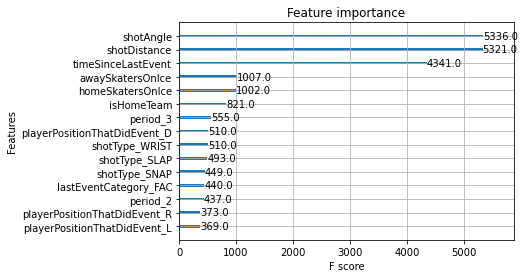

In [17]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=15)
plt.show()


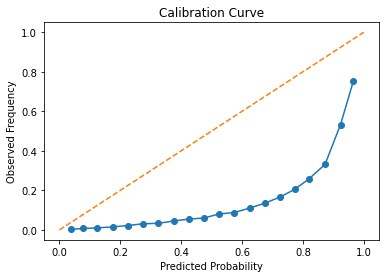

In [18]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=20)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.show()


In [19]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(xgb_model, cv=5, method="isotonic")
calibrated_model.fit(X_train, y_train)

y_calibrated = calibrated_model.predict_proba(X_test)[:, 1]


C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-p

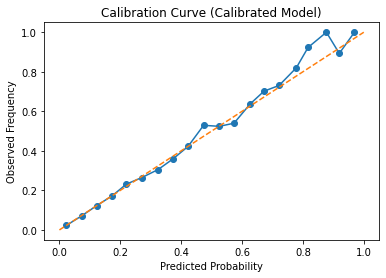

In [20]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_calibrated, n_bins=20)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve (Calibrated Model)")
plt.show()


In [23]:
print(X_test.columns.tolist())


['shotDistance', 'shotAngle', 'timeSinceLastEvent', 'homeSkatersOnIce', 'awaySkatersOnIce', 'shotRebound', 'shotRush', 'isHomeTeam', 'shotType_DEFL', 'shotType_SLAP', 'shotType_SNAP', 'shotType_TIP', 'shotType_Unknown', 'shotType_WRAP', 'shotType_WRIST', 'lastEventCategory_BLOCK', 'lastEventCategory_CHL', 'lastEventCategory_DELPEN', 'lastEventCategory_EGT', 'lastEventCategory_EISTR', 'lastEventCategory_FAC', 'lastEventCategory_GEND', 'lastEventCategory_GIVE', 'lastEventCategory_GOAL', 'lastEventCategory_HIT', 'lastEventCategory_MISS', 'lastEventCategory_PEND', 'lastEventCategory_PENL', 'lastEventCategory_PSTR', 'lastEventCategory_SHOT', 'lastEventCategory_STOP', 'lastEventCategory_TAKE', 'playerPositionThatDidEvent_D', 'playerPositionThatDidEvent_G', 'playerPositionThatDidEvent_L', 'playerPositionThatDidEvent_R', 'playerPositionThatDidEvent_Unknown', 'period_2', 'period_3', 'period_4', 'period_5', 'period_6', 'period_7', 'period_8']


In [24]:
df2 = df[['shooterPlayerId', 'shooterName']]
df3 = df2.drop_duplicates()
print(df3)


        shooterPlayerId        shooterName
0             8478178.0     Darren Raddysh
1             8478010.0      Brayden Point
2             8479661.0     Tanner Jeannot
3             8479591.0  Michael Eyssimont
4             8476887.0     Filip Forsberg
...                 ...                ...
991684        8478063.0      Shane Gersich
993024        8479595.0      Blake Hillman
994193        8480330.0        Spencer Foo
997068        8476397.0        Keegan Lowe
998467        8476283.0    Alex Broadhurst

[1974 rows x 2 columns]


In [25]:
# indices of the rows that landed in X_test
idx_test = X_test.index

# columns you want to carry along for reporting
meta_cols = ["shooterPlayerId", "shooterName", "team", "game_id", "season"]

# (optional) clean accidental spaces in column names once
df.rename(columns=lambda c: c.strip(), inplace=True)

# build a results frame for the test set
df_test = pd.DataFrame(index=idx_test)
df_test["goal"] = y_test
df_test["xG"]   = y_calibrated

# join metadata from the original dataframe using the same indices
df_test = df_test.join(df.loc[idx_test, meta_cols])

# sanity check
print(df_test.head())


        goal        xG  shooterPlayerId         shooterName  team  game_id  \
642492     0  0.063358        8478038.0         Devon Toews  HOME    21084   
55051      0  0.025341        8476931.0         Jake McCabe  HOME    20627   
273000     0  0.009711        8478399.0  Jonas Siegenthaler  HOME    20339   
276182     0  0.104524        8476934.0        Brock McGinn  AWAY    20376   
263672     0  0.101769        8473419.0       Brad Marchand  HOME    20224   

        season  
642492    2018  
55051     2023  
273000    2021  
276182    2021  
263672    2021  


In [26]:
player_xg = (
    df_test.groupby(["shooterPlayerId", "shooterName"], dropna=False)
           .agg(total_shots=("xG", "count"),
                total_xG=("xG", "sum"),
                actual_goals=("goal", "sum"))
           .reset_index()
)
player_xg["goals_minus_xG"] = player_xg["actual_goals"] - player_xg["total_xG"]
player_xg.sort_values("goals_minus_xG", ascending=False).head(10)


,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG
699,8476453.0,Nikita Kucherov,654,48.706474,75,26.293526
364,8474564.0,Steven Stamkos,523,43.494830,67,23.505170
162,8471214.0,Alex Ovechkin,832,62.646743,85,22.353257
1212,8479318.0,Auston Matthews,712,62.651813,84,21.348187
976,8477934.0,Leon Draisaitl,593,59.186339,80,20.813661
1095,8478420.0,Mikko Rantanen,516,45.058290,65,19.941710
705,8476459.0,Mika Zibanejad,580,45.758358,65,19.241642
924,8477492.0,Nathan MacKinnon,825,58.906064,78,19.093936
274,8473512.0,Claude Giroux,500,33.725877,52,18.274123
519,8475692.0,Mats Zuccarello,409,31.482636,47,15.517364


In [27]:
# keep only meaningful samples
min_shots = 100
player_xg = player_xg[player_xg.total_shots >= min_shots].copy()

# finishing metrics
player_xg["goals_per_shot"] = player_xg.actual_goals / player_xg.total_shots
player_xg["xg_per_shot"]    = player_xg.total_xG / player_xg.total_shots
player_xg["finishing_plus_minus"] = player_xg.goals_minus_xG  # alias


In [28]:
# best finishers (above expected)
player_xg.sort_values("goals_minus_xG", ascending=False).head(15)

# best xG generators
player_xg.sort_values("total_xG", ascending=False).head(15)


,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG,goals_per_shot,xg_per_shot,finishing_plus_minus
439,8475166.0,John Tavares,646,66.070978,69,2.929022,0.106811,0.102277,2.929022
1085,8478402.0,Connor McDavid,672,65.032495,77,11.967505,0.114583,0.096775,11.967505
1212,8479318.0,Auston Matthews,712,62.651813,84,21.348187,0.117978,0.087994,21.348187
162,8471214.0,Alex Ovechkin,832,62.646743,85,22.353257,0.102163,0.075297,22.353257
976,8477934.0,Leon Draisaitl,593,59.186339,80,20.813661,0.134907,0.099808,20.813661
997,8477956.0,David Pastrnak,768,58.925635,74,15.074365,0.096354,0.076726,15.074365
924,8477492.0,Nathan MacKinnon,825,58.906064,78,19.093936,0.094545,0.071401,19.093936
207,8471675.0,Sidney Crosby,619,57.246991,62,4.753009,0.100162,0.092483,4.753009
1099,8478427.0,Sebastian Aho,536,56.540369,52,-4.540369,0.097015,0.105486,-4.540369
975,8477933.0,Sam Reinhart,551,54.576428,63,8.423572,0.114338,0.099050,8.423572


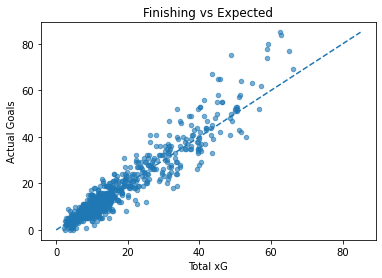

In [29]:
import matplotlib.pyplot as plt

ax = player_xg.plot.scatter(x="total_xG", y="actual_goals", alpha=0.6)
lims = [0, max(player_xg[["total_xG","actual_goals"]].max())]
ax.plot(lims, lims, linestyle="--")  # y=x line
ax.set_xlabel("Total xG"); ax.set_ylabel("Actual Goals"); ax.set_title("Finishing vs Expected")
plt.show()


In [30]:
# rebuild the same aggregation but grouped by season as well
per_season = (
    df_test.groupby(["season","shooterPlayerId","shooterName"])
           .agg(total_shots=("xG","count"),
                total_xG=("xG","sum"),
                actual_goals=("goal","sum"))
           .reset_index()
)
per_season["goals_minus_xG"] = per_season.actual_goals - per_season.total_xG
per_season

,season,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG
0,2015,8448208.0,Jaromir Jagr,40,4.126122,6,1.873878
1,2015,8460542.0,Patrik Elias,6,0.855706,0,-0.855706
2,2015,8462038.0,Shane Doan,56,4.727923,7,2.272077
3,2015,8462042.0,Jarome Iginla,48,4.184557,6,1.815443
4,2015,8464977.0,Dainius Zubrus,14,1.008121,0,-1.008121
...,...,...,...,...,...,...,...
7643,2023,8484304.0,Uvis Balinskis,4,0.224000,1,0.776000
7644,2023,8484314.0,Jiri Smejkal,5,0.253191,0,-0.253191
7645,2023,8484321.0,Nikolas Matinpalo,1,0.012098,0,-0.012098
7646,2023,8484325.0,Waltteri Merela,4,0.344597,0,-0.344597


In [32]:
# Sum across all shots in test set
total_xg = df_test["xG"].sum()
total_goals = df_test["goal"].sum()

print(f"Total xG: {total_xg:.2f}")
print(f"Total Goals: {total_goals}")
print(f"Difference (Goals - xG): {total_goals - total_xg:.2f}")


Total xG: 13808.49
Total Goals: 13759
Difference (Goals - xG): -49.49


In [35]:
# bring empty net flags from original df into df_test
df_test = df_test.join(df.loc[df_test.index, ["shotOnEmptyNet", "homeEmptyNet", "awayEmptyNet"]])


In [36]:
# Filter out empty net situations
df_no_en = df_test.copy()
df_no_en = df_no_en[
    (df_no_en["shotOnEmptyNet"] == 0) & 
    (df_no_en["homeEmptyNet"] == 0) & 
    (df_no_en["awayEmptyNet"] == 0)
]

print(f"Original shots: {len(df_test)}")
print(f"After removing empty nets: {len(df_no_en)}")



Original shots: 201301
After removing empty nets: 195931


In [37]:
total_xg = df_no_en["xG"].sum()
total_goals = df_no_en["goal"].sum()

print(f"Total xG (no EN): {total_xg:.2f}")
print(f"Total Goals (no EN): {total_goals}")
print(f"Difference (Goals - xG): {total_goals - total_xg:.2f}")


Total xG (no EN): 12840.90
Total Goals (no EN): 12708
Difference (Goals - xG): -132.90


In [42]:
meta_cols = ["shooterPlayerId", "shooterName", "season"]

# drop any that already exist in df_test
meta_cols = [c for c in meta_cols if c not in df_no_en.columns]

df_test = df_no_en.join(df.loc[df_test.index, meta_cols])


In [44]:
player_season_xg = (
    df_test.groupby(["season", "shooterPlayerId", "shooterName"])
           .agg(total_shots=("xG", "count"),
                total_xG=("xG", "sum"),
                actual_goals=("goal", "sum"))
           .reset_index()
)
player_season_xg["goals_minus_xG"] = player_season_xg["actual_goals"] - player_season_xg["total_xG"]


In [45]:
player_season_xg

,season,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG
0,2015,8448208.0,Jaromir Jagr,39,4.070098,6,1.929902
1,2015,8460542.0,Patrik Elias,6,0.855706,0,-0.855706
2,2015,8462038.0,Shane Doan,53,3.858488,6,2.141512
3,2015,8462042.0,Jarome Iginla,44,3.354127,6,2.645873
4,2015,8464977.0,Dainius Zubrus,14,1.008121,0,-1.008121
...,...,...,...,...,...,...,...
7636,2023,8484304.0,Uvis Balinskis,4,0.224000,1,0.776000
7637,2023,8484314.0,Jiri Smejkal,5,0.253191,0,-0.253191
7638,2023,8484321.0,Nikolas Matinpalo,1,0.012098,0,-0.012098
7639,2023,8484325.0,Waltteri Merela,4,0.344597,0,-0.344597
